# Software Vulnerability Detection using Deep Learning (Experiment Replication)

### Combined column experiment (All the Ys)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

## Pre-processing

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [9]:
import h5py
import pandas as pd

In [15]:
# 3 datasets available

data = h5py.File("VDISC_train.hdf5",'r')
#data = h5py.File("VDISC_validate.hdf5",'r')
#data = h5py.File("VDISC_test.hdf5",'r')

In [30]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Create a new dataframe from the HDF5 file

In [16]:
mydf = pd.DataFrame(list(data['functionSource']))

In [17]:
mydf['CWE-119']=list(data['CWE-119']); mydf['CWE-120']=list(data['CWE-120']); mydf['CWE-469']=list(data['CWE-469']); mydf['CWE-476']=list(data['CWE-476']); mydf['CWE-other']=list(data['CWE-other']) 

In [18]:
mydf.rename(columns={0:'functionSource'},inplace=True)

In [71]:
mydf.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


In [19]:
mydf.to_pickle("VDISC_train.pickle")
#mydf.to_pickle("VDISC_validate.pickle")
#mydf.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

### Importing processed datasets

In [66]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

In [4]:
### CONTINUE LATER

## Learning Phase

### Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorlfow version:  2.0.0
Eager mode:  True
GPU is available


### Setting static and global variables

In [2]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [3]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [4]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

for dataset in [train,validate,test]:
    for col in range(1,6):
        dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})

# Create source code sdata for tokenization
x_all = train['functionSource']
#x_all = x_all.append(validate['functionSource'])
#x_all = x_all.append(test['functionSource'])

In [5]:
# Overview of the datasets
pd.value_counts(train.iloc[:,1])

0    1000185
1      19286
Name: CWE-119, dtype: int64

In [5]:
one = train[train.iloc[:,1]==1].index.values.astype(int)
zero = train[train.iloc[:,1]==0].index.values.astype(int)

### Tokenizing the source codes

In [6]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(x_all))
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))

Number of tokens:  1094129


In [7]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [9]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3908040),
 ('0', 2633095),
 ('return', 2182544),
 ('i', 1720280),
 ('1', 1483872),
 ('int', 1271988),
 ('null', 1222633),
 ('the', 990541),
 ('t', 917046),
 ('n', 892342)]

### Create sequence files from the tokens

In [8]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [9]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['functionSource'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [10]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['functionSource'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [13]:
# Example data
print('Train', pd.value_counts(train.iloc[:,1]))
print('\nTest', pd.value_counts(test.iloc[:,1]))
print('\nValidate', pd.value_counts(validate.iloc[:,1]))

Train 0    1000185
1      19286
Name: CWE-119, dtype: int64

Test 0    124967
1      2452
Name: CWE-119, dtype: int64

Validate 0    125057
1      2419
Name: CWE-119, dtype: int64


### One-Hot-Enconding (OHE) on the datasets

In [11]:
y_train=[]
y_test=[]
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [15]:
# Example data
pd.value_counts(y_test[0][:,1])

0    124967
1      2452
dtype: int64

### Model Definition (CNN with Gaussian Noise and 1 Output Split)

In [12]:
# Create a random weights matrix

random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [13]:
# Must use non-sequential model building to create branches in the output layer
model = tf.keras.Sequential(name="CNN")
model.add(tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    weights=[random_weights],
                                    input_length = INPUT_SIZE))
#model.add(tf.keras.layers.GaussianNoise(stddev=0.01))
model.add(tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool1D(pool_size=5))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 13)           130000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 512)          60416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 512)          0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3276864   
_________________________________________________________________
dense_1 (Dense)              (None, 16)      

### Tensorboard Callbacks

In [14]:
## Create TensorBoard callbacks

callbackdir= 'D:\\temp\\cb'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True, 
                         write_images=True)

tbCallback.set_model(model)
mld = 'model/model-epoch-100-{epoch:02d}-single.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="val_loss",
                                         save_best_only=True, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

### Model Training

In [15]:
#ceiling = 38572
#ceiling = ‭19286
ceiling = 1019471

class_weights = {0: 1., 1: 5.}

history = model.fit(x = x_train[[*one,*zero[0:ceiling]],:],
          y = train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(),
          validation_data = (x_validate, validate.iloc[:,1].to_numpy()),
          epochs = 40,
          batch_size = 128,
          verbose =2,
          class_weight= class_weights,
          callbacks=[mcp,tbCallback])

with open('history/history-Epoch40-CNN-single', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 1019471 samples, validate on 127476 samples
Epoch 1/40

Epoch 00001: val_loss improved from inf to 0.30277, saving model to model/model-epoch-100-01-single.hdf5
1019471/1019471 - 173s - loss: 0.3170 - accuracy: 0.9805 - val_loss: 0.3028 - val_accuracy: 0.9810
Epoch 2/40

Epoch 00002: val_loss improved from 0.30277 to 0.25846, saving model to model/model-epoch-100-02-single.hdf5
1019471/1019471 - 166s - loss: 0.2908 - accuracy: 0.9811 - val_loss: 0.2585 - val_accuracy: 0.9806
Epoch 3/40

Epoch 00003: val_loss improved from 0.25846 to 0.21230, saving model to model/model-epoch-100-03-single.hdf5
1019471/1019471 - 170s - loss: 0.2212 - accuracy: 0.9668 - val_loss: 0.2123 - val_accuracy: 0.9670
Epoch 4/40

Epoch 00004: val_loss improved from 0.21230 to 0.20217, saving model to model/model-epoch-100-04-single.hdf5
1019471/1019471 - 169s - loss: 0.2041 - accuracy: 0.9644 - val_loss: 0.2022 - val_accuracy: 0.9612
Epoch 5/40

Epoch 00005: val_loss improved from 0.20217 to 0.19732, sav

In [ ]:
# Continue training for another 100 epochs

history40 = model.fit(x = x_train[[*one,*zero[0:ceiling]],:],
          y = train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(),
          validation_data = (x_validate, validate.iloc[:,1].to_numpy()),
          epochs = 20,
          batch_size = 128,
          verbose =2,
          class_weight= class_weights,
          callbacks=[mcp,tbCallback])

with open('history/history-Epoch40-CNN-single', 'wb') as file_pi:
    pickle.dump(history40.history, file_pi)


### Load the model

In [16]:
# Load model
model = tf.keras.models.load_model("model/model-epoch-100-36-single.hdf5")

### Model Evaluation using Training Set

In [ ]:
results = model.evaluate(x_train[[*one,*zero[0:ceiling]],:], train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), verbose=0, batch_size=128, )
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted = model.predict_classes(x_train[[*one,*zero[0:ceiling]],:])
predicted_prob = model.predict(x_train[[*one,*zero[0:ceiling]],:])

print('\nConfusion Matrix')
#predicted = model.predict_classes(x_test)
confusion = sklearn.metrics.confusion_matrix(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)
print(confusion)

tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_score=predicted_prob)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_score=predicted_prob)))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))

### Model Evaluation using Testing Set

In [17]:
## Test data

results = model.evaluate(x_test, test.iloc[:,1].to_numpy(), batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted = model.predict_classes(x_test)
predicted_prob = model.predict(x_test)

confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=test.iloc[:,1].to_numpy(), y_score=predicted_prob)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=test.iloc[:,1].to_numpy(), y_score=predicted_prob)))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss: 0.07783142023938047
accuracy: 0.96657485
[[121376   3591]
 [   668   1784]]

TP: 1784
FP: 3591
TN: 121376
FN: 668

Accuracy: 0.9665748436261468
Precision: 0.33190697674418607
Recall: 0.7275693311582382
F-measure: 0.45585792768621436
Precision-Recall AUC: 0.37103943026150804
AUC: 0.9437150902128537
MCC: 0.47762199896225743


### Plot The Model's Training History

In [18]:
model.metrics_names

['loss', 'accuracy']

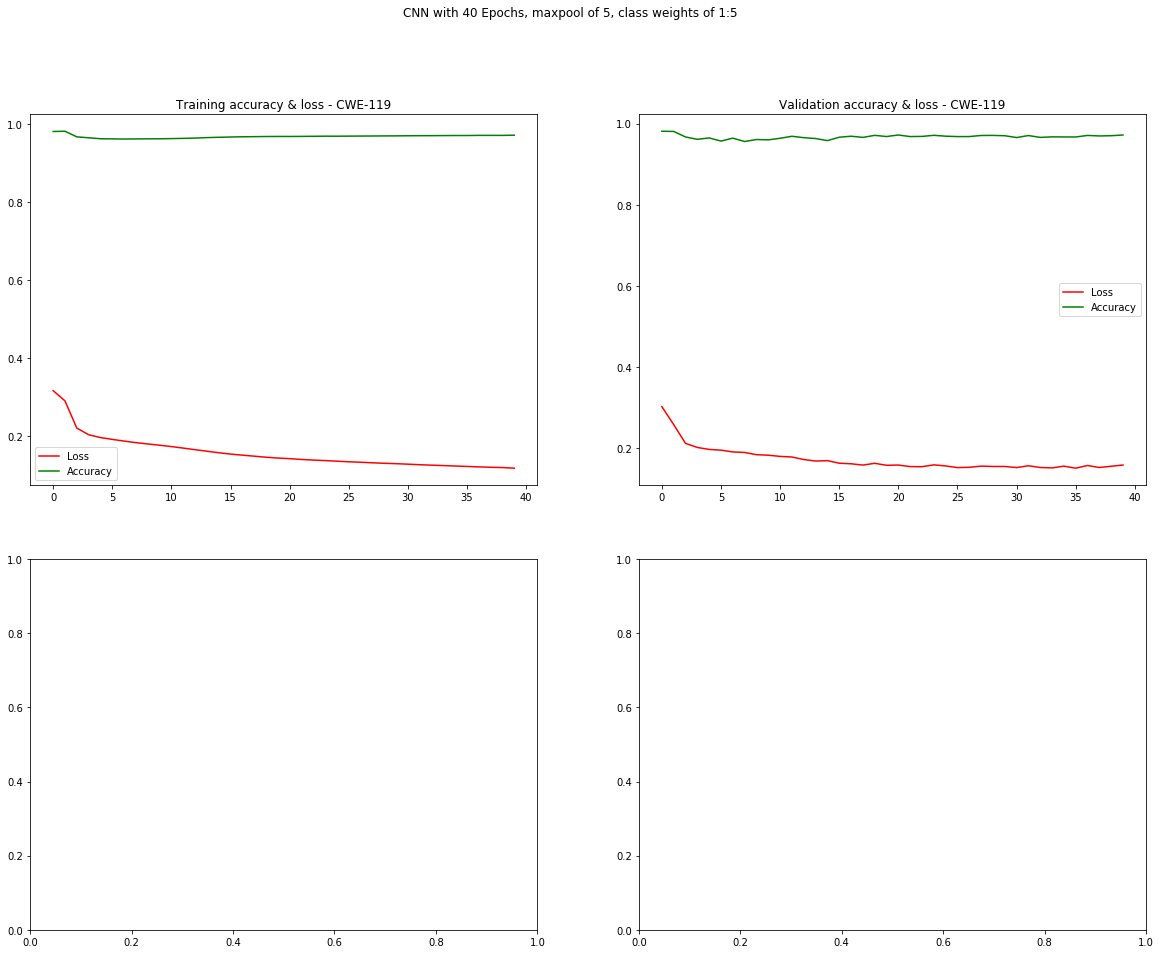

In [21]:
epochs_range = range(len(history.history[model.metrics_names[1]]))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
fig.suptitle('CNN with 40 Epochs, maxpool of 5, class weights of 1:5')

axs[0,0].plot(epochs_range, history.history[model.metrics_names[0]], 'b', label='Loss', color='red')
axs[0,0].plot(epochs_range, history.history[model.metrics_names[1]], 'b', label='Accuracy', color='green')
axs[0,0].set_title('Training accuracy & loss - CWE-119')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[0])], 'b', label='Loss', color='red')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='Accuracy', color='green')
axs[0,1].set_title('Validation accuracy & loss - CWE-119')
axs[0,1].legend()




## Discussion (Test results only)

The results are as below (20 epochs unless stated):

| No.|MaxPool|Weights (0 : 1)|TP|FP|TN|FN|Acc|Precision|Recall|PR-AUC|AUC|MCC|F1|
|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|
|  1	|  4	| 1 : 50  	|  2090   	|  9883  	| 115084  	|362| 0.9195  	|  0.1745  	| 0.8523 	| 0.3272| 0.9433|0.3640| 0.2897|
|  2	|  4	| 1 : 35  	|  2089	    |  8480  	| 116487  	|363| 0.9305   	|  0.1976  	| 0.8519 	| 0.3516| 0.9450|0.3905| 0.3208|
|  3	|  4	| 1 : 25   	|  2055 	|  7442  	| 117525  	|397| 0.9384  	|  0.2163 	| 0.8380  	| 0.3472| 0.9455|0.4072| 0.3439|
|  4	|  4	| 1 : 20   	|  2040 	|  6989  	| 117978  	|412| 0.9419  	|  0.2259 	| 0.8319  	| 0.3441| 0.9459|0.4154| 0.3553|
|  5	|  4	| 1 : 15   	|  1994 	|  5937  	| 119030  	|458| 0.9498  	|  0.2514 	| 0.8132  	| 0.3533| 0.9455|0.4354| 0.3840|
|  6	|  4	| 1 : 10   	|  1930 	|  5257  	| 119710  	|522| 0.9546  	|  0.2685 	| 0.7871  	| 0.3479| 0.9463|0.4436| 0.4004|
|  7	|  4	| 1 : 5   	|  1610 	|  3240  	| 121727  	|842| 0.9679  	|  0.3319 	| 0.6566  	| 0.3343| 0.9430|0.4527| 0.4409|
|  8	|  3	| 1 : 5 (40ep)|  1801 	|  3780  	| 121187  	|651| 0.9652  	|  0.3227 	| 0.7345  	| 0.3661| 0.9429|0.4727| 0.4484|
|  9	|  4	| 1 : 5 (40ep)|  1740 	|  3417  	| 121550  	|712| 0.9675  	|  0.3374 	| 0.7096  	| 0.3717| 0.9436|0.4756| 0.4573|
|  10	|  5	| 1 : 5 (40ep)|  1784 	|  3591  	| 121376  	|668| 0.9665  	|  0.3319 	| 0.7275  	| 0.3710| 0.9437|0.4776| 0.4558|

In [46]:
np.unique((predicted_prob>0.5) == (predicted==1), return_counts=True)

(array([ True]), array([127419], dtype=int64))